adapted from Gao et al. 2010 (http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5545418)

In [222]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import pickle
from astropy.table import Column
from astropy.table import Table
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist
%matplotlib inline

# preparing the input data

In [2]:
# loading training labels
f = open('/Users/eilers/Dropbox/cygnet/data/training_labels_apogee_tgas.pickle', 'r')
training_labels = pickle.load(f)
f.close()

# loading normalized spectra
f = open('/Users/eilers/Dropbox/cygnet/data/apogee_spectra_norm.pickle', 'r')    
spectra = pickle.load(f)
f.close()

wl = spectra[:, 0, 0]
fluxes = spectra[:, :, 1].T
ivars = (1./(spectra[:, :, 2]**2)).T 

In [3]:
# remove duplicates       
foo, idx = np.unique(training_labels['APOGEE_ID'], return_index = True)
training_labels = training_labels[idx]
fluxes = fluxes[idx, :]
ivars = ivars[idx, :]
        
# data masking       
masking = training_labels['K'] < 0.
training_labels = training_labels[~masking]
fluxes = fluxes[~masking]
ivars = ivars[~masking]

# scaling of data and training labels?!

In [4]:
# calculate K_MAG_ABS and Q

Q = 10**(0.2*training_labels['K']) * training_labels['parallax']/100.                    # assumes parallaxes is in mas
Q_err = training_labels['parallax_error'] * 10**(0.2*training_labels['K'])/100. 
Q = Column(Q, name = 'Q_MAG')
Q_err = Column(Q_err, name = 'Q_MAG_ERR')
training_labels.add_column(Q, index = 12)
training_labels.add_column(Q_err, index = 13)

In [5]:
# latex

latex = {}
latex["TEFF"] = r"$T_{\rm eff}$"
latex["LOGG"] = r"$\log g$"
latex["FE_H"] = r"$\rm [Fe/H]$"
latex["ALPHA_M"] = r"$[\alpha/\rm M]$"
latex["C_FE"] = r"$\rm [C/Fe]$"
latex["N_FE"] = r"$\rm [N/Fe]$"
latex["Q_MAG"] = r"$Q$"

In [10]:
def make_label_input(labels, training_labels):
    tr_label_input = np.array([training_labels[x] for x in labels]).T
    tr_ivar_input = 1./((np.array([training_labels[x+'_ERR'] for x in labels]).T)**2)
    for x in range(tr_label_input.shape[1]):
        bad = np.logical_or(tr_label_input[:, x] < -100., tr_label_input[:, x] > 9000.) # magic
        tr_label_input[bad, x] = np.median(tr_label_input[:, x])
        tr_ivar_input[bad, x] = 0.
    # remove one outlier in T_eff and [N/Fe]!
    bad = tr_label_input[:, 0] > 5200.
    tr_label_input[bad, 0] = np.median(tr_label_input[:, 0])
    tr_ivar_input[bad, 0] = 0.  
    #bad = tr_label_input[:, 5] < -0.6
    #tr_label_input[bad, 5] = np.median(tr_label_input[:, 5])
    #tr_ivar_input[bad, 5] = 0.     
    return tr_label_input, tr_ivar_input

In [128]:
labels = np.array(['TEFF', 'FE_H', 'LOGG']) #, 'ALPHA_M', 'Q_MAG', 'N_FE', 'C_FE'])
Nlabels = len(labels)
latex_labels = [latex[l] for l in labels]
tr_label_input, tr_ivar_input = make_label_input(labels, training_labels)
print(Nlabels, tr_label_input.shape, tr_ivar_input.shape, fluxes.shape, ivars.shape)

 (3, (2180, 3), (2180, 3), (2180, 8575), (2180, 8575))


In [ ]:
# scale and pivot labels!

In [270]:
# take subset of data as input data
X = fluxes[:100, 500:700]
Y = tr_label_input[:100, :]
print X.shape, Y.shape 
N = X.shape[0]
D = X.shape[1]
L = Y.shape[1]
assert Y.shape[0] == N

(100, 200) (100, 3)


# Supervised GPLVM

X: input spectra -- N x D

Y: input labels -- N x L

Z: latent space -- N x Q

In [352]:
def logLikelihood_Z(pars, X, Y, hyper_params):
    
    Z = np.reshape(pars, (Y.shape[0], Y.shape[1]))  
    theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2 = hyper_params    
    kernel1 = kernelRBF(Z, theta_rbf, theta_band, sigmax2)
    kernel2 = kernelRBF(Z, gamma_rbf, gamma_band, sigmay2)
    
    Lx = LxOrLy(kernel1, X)          # eq. (18)
    Ly = LxOrLy(kernel2, Y)          # eq. (19)    
    print('L_Z: L_x={} '.format(Lx) + 'L_y={}'.format(Ly))
    L = Lx + Ly #+ logPrior(Z)       # eq. (20)     
    gradL = dLdZ(X, Y, Z, kernel1, kernel2, theta_band, gamma_band)    
    # reshape gradL back into 1D array
    gradL = np.reshape(gradL, (Y.shape[0] * Y.shape[1], ))
        
    return -L, -gradL
                    
def logLikelihood_hyper(pars, X, Y, Z):
    
    Z = np.reshape(Z, (Y.shape[0], Y.shape[1]))      
    theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2 = pars   
    kernel1 = kernelRBF(Z, theta_rbf, theta_band, sigmax2)
    kernel2 = kernelRBF(Z, gamma_rbf, gamma_band, sigmay2)
    
    Lx = LxOrLy(kernel1, X)          # eq. (18)
    Ly = LxOrLy(kernel2, Y)          # eq. (19)    
    print('L_h: L_x={} '.format(Lx) + 'L_y={}'.format(Ly))
    L = Lx + Ly #+ logPrior(Z)        # eq. (20) 
    
    gradL = dLdhyper(X, Y, Z, kernel1, kernel2, pars)  
    return -L, -gradL


# eq. (21), (22)
def dLdZ(X, Y, Z, kernel1, kernel2, theta_band, gamma_band):    
    A = np.zeros((100, 100, 3))
    for i in range(3):
        A[:, :, i] = cdist(Z[:, i, None], Z[:, i, None])
    #dlnpdZ =       # eq. (27)
    xx = dLdK(kernel1, X)[:, :, None] * dKdZ(theta_band, kernel1, A) + dLdK(kernel2, Y)[:, :, None] * dKdZ(gamma_band, kernel2, A) #+ dlnpdZ    
    gradL = np.sum(xx, axis=0)   
    return gradL


# eq. (25), (26)
def dKdZ(band, kernel, A):
    return band * np.dot(kernel, A)      # should be shape: N x Q...?


# eq. (23), (24)
def dLdK(K, data):         
    grad_dLdK = np.dot((np.dot(np.dot(np.linalg.inv(K), X), X.T)), np.linalg.inv(K)) - data.shape[1] * np.linalg.inv(K)
    return grad_dLdK                     # shape: N x N


# eq. (28)
def dLdhyper(X, Y, Z, kernel1, kernel2, hyper_params):    
    theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2 = hyper_params    
    dLdtheta = dLdK(kernel1, X) * dKdhyper(Z, kernel1, theta_rbf, theta_band, sigmax2)
    dLdgamma = dLdK(kernel2, Y) * dKdhyper(Z, kernel2, gamma_rbf, gamma_band, sigmay2)
    # sum over entries of K 
    dLdtheta = np.sum(np.sum(dLdtheta, axis=1), axis=1)
    dLdgamma = np.sum(np.sum(dLdgamma, axis=1), axis=1)
    return np.hstack((dLdtheta, dLdgamma))


# eq. (29), (30)
def dKdhyper(Z, K, rbf, band, sigma2):
    dKdrbf = 1./rbf * K
    B = -0.5 * cdist(Z, Z).T * cdist(Z, Z)
    dKdband = np.dot(K, B)
    dKdsigma2 = np.eye(K.shape[0])    
    return dKdrbf, dKdband, dKdsigma2


# eq. (18), (19)
def LxOrLy(K, data):   
    L_term1 = -0.5 * data.shape[0] * data.shape[1] * np.log(2.*np.pi)
    L_term2 = -0.5 * data.shape[1] * np.log(np.linalg.det(K))
    L_term3 = -0.5 * np.matrix.trace(np.dot(np.dot(np.linalg.inv(K), X), X.T))
    return L_term1 + L_term2 + L_term3


#def logPrior(Z):   
#    lnpZ = 
#    return lnpZ


# radius basis function
def kernelRBF(Z, rbf, band, sigma2):    
    kernel = rbf * rbf_kernel(Z, gamma = 0.5*band) + sigma2 * np.eye(Z.shape[0])
    return kernel


def PCAInitial(X, Q):
    pca = PCA(Q)
    Z_initial = pca.fit_transform(X)
    return Z_initial

In [353]:
def test_likelihood_h(pars, X, Y, Z):
    
    q, dldq = logLikelihood_hyper(pars, X, Y, Z)
    
    for k in range(len(pars)):
        pars1 = 1. * pars
        tiny = 1e-7 * pars[k]
        pars1[k] += tiny
        q1, foo = logLikelihood_hyper(pars1, X, Y, Z)
        dldqk = (q1 - q)/tiny
        print(k, q, q1, dldqk, dldq[k], (dldq[k]-dldqk)/(dldq[k]+dldqk))
    return

def test_likelihood_Z(pars, X, Y, hyper_params):
    
    q, dldq = logLikelihood_Z(pars, X, Y, hyper_params)
    
    for k in range(len(pars)):
        pars1 = 1. * pars
        tiny = 1e-7 * pars[k]
        pars1[k] += tiny
        q1, foo = logLikelihood_Z(pars1, X, Y, hyper_params)
        dldqk = (q1 - q)/tiny
        print(k, q, q1, dldqk, dldq[k], (dldq[k]-dldqk)/(dldq[k]+dldqk))
    return

In [362]:
# initialization 
theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2 = 1, 1, 1, 1, 1, 1
hyper_params = np.array([theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2])

Q = 3
Z_initial = Y[:] #PCAInitial(X, Q)
Z = Z_initial[:]
Z = np.reshape(Z, (N*Q, ))
print Z.shape

(300,)


In [363]:
# testing likelihood functions
test_likelihood_h(hyper_params, X, Y, Z)
test_likelihood_Z(Z, X, Y, hyper_params)

L_h: L_x=-28793.3698964 L_y=-4298.46022939
L_h: L_x=-28793.3701843 L_y=-4298.46022939
(0, 33091.830125812339, 33091.830413729724, 2879.1738441213965, 12149.117399109371, 0.61683283914020892)
L_h: L_x=-28793.3699447 L_y=-4298.46022939
(1, 33091.830125812339, 33091.830174126815, 483.14475861843675, 30240170130.041294, 0.99999996804616176)
L_h: L_x=-28793.3702697 L_y=-4298.46022939
(2, 33091.830125812339, 33091.83049904323, 3732.3089054552838, 7464.6179297245189, 0.33333334040753343)
L_h: L_x=-28793.3698964 L_y=-4298.45998646
(3, 33091.830125812339, 33091.829882883758, -2429.285814287141, -7550.8826008906262, 0.513177390755711)
L_h: L_x=-28793.3698964 L_y=-4298.46026262
(4, 33091.830125812339, 33091.830159049823, 332.37483876291662, 30240170130.041294, 0.99999997801766094)
L_h: L_x=-28793.3698964 L_y=-4298.46006014
(5, 33091.830125812339, 33091.829956571957, -1692.4038209253922, -3384.8077262320821, 0.33333334441307622)
L_Z: L_x=-28793.3698964 L_y=-4298.46022939
L_Z: L_x=-28793.3698964 L_

In [ ]:
# iterative algorithm (Table 1)

max_iter = 1
for t in range(max_iter):
    
    # optimize hyperparameters
    print("optimizing hyper parameters")
    res = op.minimize(logLikelihood_hyper, x0 = hyper_params, args = (X, Y, Z), method = 'L-BFGS-B', jac = True, 
                      options={'gtol':1e-12, 'ftol':1e-12})
    
    # update hyperparameters
    hyper_params = res.x
             
    # optimize Z
    print("optimizing latent parameters")
    res = op.minimize(logLikelihood_Z, x0 = Z, args = (X, Y, hyper_params), method = 'L-BFGS-B', jac = True, 
                      options={'gtol':1e-12, 'ftol':1e-12})
             
    # update Z
    Z = res.x
    
    # check convergence
 
Z_final = np.reshape(Z, (N, Q))

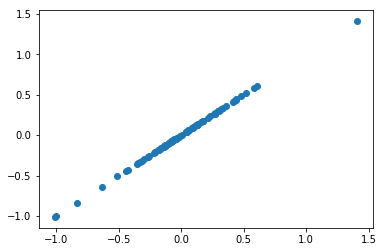

In [303]:
plt.scatter(Z_initial[:, 0], Z_final[:, 0])